In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


array([[0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1]])


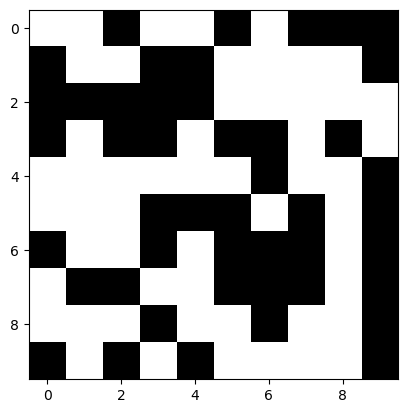

In [2]:
maze_size = (10, 10)  
maze_rand = np.random.choice([0, 1], size=maze_size)
print(repr(maze_rand))
plt.imshow(maze_rand, cmap='binary')
plt.show()

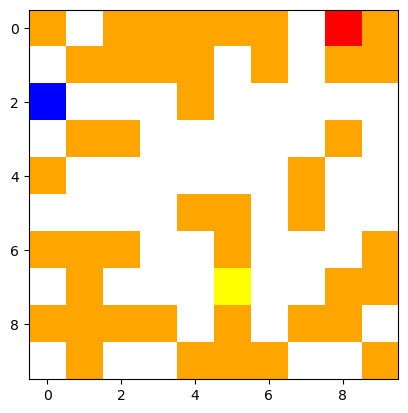

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (7, 5)]
(101, 4)
Q matrix: 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 

In [83]:
class Maze_env:
    def __init__(self , start, target, coins, maze):
        self.maze = maze
        self.target = target
        self.start = start
        self.coins = coins
        self.position = 0
        self.R = 0
        self.Q = 0
        self.states = []
        self.coin_collected = False
        
    def plot_env(self):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[self.start] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.show()
        
    def plot_env_position(self, position, timestep):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[position] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.savefig(f'img/plot_{timestep:06d}.png', dpi=300)
        plt.show()
        plt.close() 
        
    def create_r_matrix(self):
        actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        num_states = self.maze.shape[0] * self.maze.shape[1]
        R = np.full((num_states, 4), np.nan)

        state_index = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
            # If the cell is not a wall
                if self.maze[i, j] == 0:
                    for index, action in enumerate(actions):
                        new_position = (i + action[0], j + action[1])
                        # If action leads to a valid state
                        if (0 <= new_position[0] < self.maze.shape[0] and
                            0 <= new_position[1] < self.maze.shape[1] and
                            self.maze[new_position] == 0):
                            # Calculate the state number for the new position
                            # Set reward to 0
                            R[state_index, index] = -5

                            # If action leads to goal state set reward to 100
                            if new_position == self.target:
                                R[state_index, index] = 1000
                            if new_position == self.coins:
                                R[state_index, index] = 200
                state_index += 1
                            
        self.R = R
        print(self.R.shape)
        return self.R
    
    def reward(self, state, action):
        state = self.states[state]
        x, y = state
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1
        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return -1  # hit a wall (including edges wall?)
        elif (x, y) == self.target:
            print("Reached Target!")
            print((x,y))
            
            return 0 + int(self.coin_collected == True) # reached the target and bonus if collected coin
        elif (x, y) == self.coins and not self.coin_collected:
            print("DING DING DING")
            return 10
        else:
            return -0.005  # regular step
        
    def transition(self, state, action):
        state_new = self.states[state]
        x, y = state_new
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return self.states.index(state_new)  # hit a wall, stay in the same state
        else:
            if (x, y) == self.coins and not self.coin_collected:
                self.coin_collected = True
                return 100 #specific index for coin
            else:
                return self.states.index((x,y))  # move to the new state
        
    
    def create_q_matrix(self):
        coord_to_index = []
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                coord_to_index.append((i,j))
        coord_to_index.append(self.coins)
        print(coord_to_index)
                
        num_states = self.maze.shape[0] * self.maze.shape[1] + 1
        num_actions = 4
        self.Q = np.zeros((num_states, num_actions))
        print(self.Q.shape)
        self.states = coord_to_index
        return self.Q, coord_to_index

maze = np.array([
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
                ])
# env = Maze_env((2,0),(0,8),(6,6), maze) 
env = Maze_env((2,0),(0,8),(7,5), maze) 
env.plot_env()
# R = env.create_r_matrix()
# print('R matrix: \n\n{}'.format(R))
Q, coord_to_index = env.create_q_matrix()
print('Q matrix: \n\n{}'.format(Q))




In [84]:
class Q_learning:
    
    def __init__(self, alpha, gamma, epsilon, episodes, steps, env, states):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = 1.0
        self.states = states

#         self.R = env.R
#         self.R_mod = self.R.copy()
        self.Q = env.Q
        self.episodes = episodes
        self.steps = steps
        self.start = env.start
        self.target = self.states.index(env.target)
        self.coins = env.coins
        self.env = env
        self.episodes_rewards = []
        self.max_list_size = 10
        self.list_rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.threshold = 2
        self.window_size = 4
        self.current_average = 0
        
        print("Initial Q matrix is '{}'".format(self.Q))

    def plot_rewards(self):
        plt.plot(self.episodes_rewards)
        plt.show()
        
    def show_Q_spec(self,coord):
        print(q_learning.Q[self.states.index(coord)])
        
    def greedy_policy(self, state):
#                 available_actions = np.where(~np.isnan(self.R_mod[s]))[0]
#                 q_values = [self.Q[s,a] for a in available_actions]
#                 best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
        
        available_actions = np.array([0,1,2,3])
        q_values = [self.Q[state,a] for a in available_actions]
        best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]

        if np.random.uniform() < self.epsilon:
            a = np.random.choice(4)
#                     a = np.random.choice(available_actions)
        else:
#                     a = np.argmax(self.Q[s,:])
            a = np.random.choice(best_actions)
        return a
    
    def softmax_policy(self, state, temperature = 1.0):
        available_actions = np.array([0,1,2,3])
        q_values = np.array([self.Q[state,a] for a in available_actions])
        max_q_value = np.max(q_values)
        exp_values = np.exp((q_values - max_q_value) / temperature)
        action_probs = exp_values / np.sum(exp_values)

        # Sample an action based on the probabilities
        selected_action = np.random.choice(len(action_probs), p=action_probs)
        return selected_action
        
    def train(self):
        print(self.states)
        print("Starting taget is '{}'".format(self.target))
        for episode in range(self.episodes):
            s = self.states.index(self.start)
            print("Starting state is '{}'".format(s))
            episode_reward = 0
            env.coin_collected = False
#             self.R_mod = self.R
            for timestep in range(self.steps):

                # Epsilon-greedy action choice
#                 a = self.greedy_policy(s)
                a = self.softmax_policy(s, self.temperature)

                # Environment updating
                r = env.reward(s, a)
#                 r = self.R_mod[s,a]
                episode_reward += r
                new_s = env.transition(s, a)
                # Doubts coordinates to Q system?
                # Q value updating
#                 print(new_s)
                self.Q[s,a] = self.Q[s,a] + self.alpha * ( r + self.gamma * np.max(self.Q[new_s,:]) - self.Q[s,a])

                if new_s == self.target:
                    break
                s = new_s
            
            self.episodes_rewards.append(episode_reward)
            
            self.list_rewards.append(episode_reward)
            if len(self.list_rewards) > self.max_list_size:
                self.list_rewards.pop(0)
            window = self.list_rewards[-self.window_size:]
            window_average = sum(window) / self.window_size
#             if abs(self.current_average - window_average) < self.threshold:
#                 print(f"Average exceeded threshold at episode {episode}. STOPPING!")
#                 break 
            self.current_average = window_average

            if episode % 2 == 0:
                print('Episode {} finished. Episode Reward {}. Timesteps {}. Average {}'.format(episode,episode_reward,timestep, window_average))
            self.epsilon = max(self.epsilon*0.999,0.01)
            self.temperature = max(self.temperature*0.998,0.001)

            print(self.temperature)
            
    def create_video(self):
        image_folder = 'img'  # Directory containing your saved plot images
        video_name = 'video_agent.mp4'

        images = [img for img in os.listdir(image_folder) if img.endswith((".jpg", ".jpeg", ".png"))]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
    
    def test(self, limit):

        s = self.states.index(self.start)
        print("Starting state is '{}'".format(s))
        episode_reward = 0
        env.coin_collected = False
        for timestep in range(limit):
            self.env.plot_env_position(self.states[s], timestep)
            print(self.Q[s])
            a = np.argmax(self.Q[s])
            print(a)

            # Environment updating
            r = env.reward(s, a)
            print(r)
            episode_reward += r
            temp_new_s = env.transition(s, a)
#             new_s = self.states.index(temp_new_s)

            if temp_new_s == self.target:
                self.env.plot_env_position(self.states[temp_new_s], timestep)
                break
            s = temp_new_s
        print('Episode Reward {}.Q matrix values:\n{}'.format(episode_reward,self.Q.round(1)))
        self.create_video()



            

In [85]:
q_learning = Q_learning(1, 0.999, 1, 6000, 2000, env, coord_to_index)
q_learning.train()

Initial Q matrix is '[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

Episode 56 finished. Episode Reward -95.51499999999946. Timesteps 1999. Average -84.07249999999996
0.8921561084616334
Starting state is '20'
DING DING DING
0.8903717962447101
Starting state is '20'
DING DING DING
Episode 58 finished. Episode Reward -73.62500000000054. Timesteps 1999. Average -82.82874999999967
0.8885910526522206
Starting state is '20'
DING DING DING
0.8868138705469162
Starting state is '20'
DING DING DING
Episode 60 finished. Episode Reward -114.4199999999986. Timesteps 1999. Average -89.79374999999911
0.8850402428058224
Starting state is '20'
DING DING DING
0.8832701623202107
Starting state is '20'
DING DING DING
Episode 62 finished. Episode Reward -85.5649999999992. Timesteps 1999. Average -92.28124999999885
0.8815036219955703
Starting state is '20'
DING DING DING
0.8797406147515792
Starting state is '20'
DING DING DING
Episode 64 finished. Episode Reward -120.38999999999785. Timesteps 1999. Average -97.00749999999883
0.877981133522076
Starting state is '20'
DING DIN

Episode 134 finished. Episode Reward -55.71500000000083. Timesteps 1999. Average -58.45125000000094
0.763173134540909
Starting state is '20'
DING DING DING
0.7616467882718272
Starting state is '20'
DING DING DING
Episode 136 finished. Episode Reward -71.63500000000043. Timesteps 1999. Average -66.16250000000117
0.7601234946952835
Starting state is '20'
DING DING DING
0.7586032477058929
Starting state is '20'
DING DING DING
Episode 138 finished. Episode Reward -45.7650000000006. Timesteps 1999. Average -74.12250000000043
0.7570860412104812
Starting state is '20'
DING DING DING
0.7555718691280602
Starting state is '20'
DING DING DING
Episode 140 finished. Episode Reward -108.44999999999798. Timesteps 1999. Average -81.58499999999964
0.7540607253898041
Starting state is '20'
DING DING DING
0.7525526039390245
Starting state is '20'
DING DING DING
Episode 142 finished. Episode Reward -59.695000000002565. Timesteps 1999. Average -79.34625000000025
0.7510474987311464
Starting state is '20'
DI

0.6515321268390141
Starting state is '20'
DING DING DING
Episode 214 finished. Episode Reward -53.7250000000015. Timesteps 1999. Average -56.46125000000144
0.6502290625853361
Starting state is '20'
DING DING DING
0.6489286044601654
Starting state is '20'
DING DING DING
Episode 216 finished. Episode Reward -66.66000000000096. Timesteps 1999. Average -55.46625000000103
0.6476307472512451
Starting state is '20'
DING DING DING
0.6463354857567426
Starting state is '20'
DING DING DING
Episode 218 finished. Episode Reward -1.9849999999999854. Timesteps 1999. Average -45.018750000000686
0.6450428147852291
Starting state is '20'
DING DING DING
0.6437527291556586
Starting state is '20'
DING DING DING
Episode 220 finished. Episode Reward -85.56499999999916. Timesteps 1999. Average -53.47625000000036
0.6424652236973473
Starting state is '20'
DING DING DING
0.6411802932499525
Starting state is '20'
DING DING DING
Episode 222 finished. Episode Reward -42.780000000000506. Timesteps 1999. Average -62.

Episode 290 finished. Episode Reward -42.78000000000092. Timesteps 1999. Average -41.03875000000048
0.5584541397099421
Starting state is '20'
DING DING DING
0.5573372314305222
Starting state is '20'
DING DING DING
Episode 292 finished. Episode Reward -28.849999999999714. Timesteps 1999. Average -39.54625000000071
0.5562225569676611
Starting state is '20'
DING DING DING
0.5551101118537257
Starting state is '20'
DING DING DING
Episode 294 finished. Episode Reward -31.83499999999958. Timesteps 1999. Average -37.805000000000376
0.5539998916300183
Starting state is '20'
DING DING DING
0.5528918918467582
Starting state is '20'
DING DING DING
Episode 296 finished. Episode Reward -61.68500000000175. Timesteps 1999. Average -45.26750000000072
0.5517861080630647
Starting state is '20'
DING DING DING
0.5506825358469386
Starting state is '20'
DING DING DING
Episode 298 finished. Episode Reward -38.80000000000014. Timesteps 1999. Average -43.775000000000674
0.5495811707752447
Starting state is '20'

0.4767605107144487
Starting state is '20'
DING DING DING
Episode 370 finished. Episode Reward -27.85499999999996. Timesteps 1999. Average -32.82999999999993
0.4758069896930198
Starting state is '20'
DING DING DING
0.4748553757136338
Starting state is '20'
DING DING DING
Episode 372 finished. Episode Reward -23.87499999999997. Timesteps 1999. Average -26.859999999999854
0.47390566496220654
Starting state is '20'
DING DING DING
0.47295785363228215
Starting state is '20'
DING DING DING
Episode 374 finished. Episode Reward -32.829999999999494. Timesteps 1999. Average -24.621249999999883
0.4720119379250176
Starting state is '20'
DING DING DING
0.4710679140491676
Starting state is '20'
DING DING DING
Episode 376 finished. Episode Reward -18.90000000000037. Timesteps 1999. Average -29.347500000000327
0.47012577822106927
Starting state is '20'
DING DING DING
0.46918552666462715
Starting state is '20'
DING DING DING
Episode 378 finished. Episode Reward -31.834999999999738. Timesteps 1999. Avera

0.40783312464750954
Starting state is '20'
DING DING DING
Episode 448 finished. Episode Reward -25.86500000000009. Timesteps 1999. Average -26.61125000000017
0.4070174583982145
Starting state is '20'
DING DING DING
0.4062034234814181
Starting state is '20'
DING DING DING
Episode 450 finished. Episode Reward -19.895000000000177. Timesteps 1999. Average -21.13875000000008
0.40539101663445526
Starting state is '20'
DING DING DING
0.40458023460118636
Starting state is '20'
DING DING DING
Episode 452 finished. Episode Reward -28.849999999999888. Timesteps 1999. Average -16.41250000000008
0.403771074131984
Starting state is '20'
DING DING DING
0.40296353198372004
Starting state is '20'
DING DING DING
Episode 454 finished. Episode Reward -30.83999999999953. Timesteps 1999. Average -22.382499999999848
0.4021576049197526
Starting state is '20'
DING DING DING
0.40135328970991313
Starting state is '20'
DING DING DING
Episode 456 finished. Episode Reward -27.854999999999528. Timesteps 1999. Averag

Episode 528 finished. Episode Reward -0.9899999999999953. Timesteps 1999. Average -9.198750000000182
0.34678183553898484
Starting state is '20'
DING DING DING
0.34608827186790686
Starting state is '20'
DING DING DING
Episode 530 finished. Episode Reward -0.9899999999999936. Timesteps 1999. Average -3.4775000000000342
0.34539609532417104
Starting state is '20'
DING DING DING
0.3447053031335227
Starting state is '20'
DING DING DING
Episode 532 finished. Episode Reward -0.9899999999999847. Timesteps 1999. Average -0.9899999999999922
0.3440158925272557
Starting state is '20'
DING DING DING
0.3433278607422012
Starting state is '20'
DING DING DING
Episode 534 finished. Episode Reward -2.979999999999988. Timesteps 1999. Average -1.4874999999999918
0.34264120502071677
Starting state is '20'
DING DING DING
0.3419559226106753
Starting state is '20'
DING DING DING
Episode 536 finished. Episode Reward -7.954999999999947. Timesteps 1999. Average -5.218750000000016
0.34127201076545394
Starting state

0.2972405253023076
Starting state is '20'
DING DING DING
Episode 606 finished. Episode Reward -14.920000000000327. Timesteps 1999. Average -12.930000000000172
0.296646044251703
Starting state is '20'
DING DING DING
0.2960527521631996
Starting state is '20'
DING DING DING
Episode 608 finished. Episode Reward -14.92000000000028. Timesteps 1999. Average -12.432500000000188
0.29546064665887317
Starting state is '20'
DING DING DING
0.29486972536555545
Starting state is '20'
DING DING DING
Episode 610 finished. Episode Reward -3.974999999999951. Timesteps 1999. Average -11.935000000000144
0.29427998591482435
Starting state is '20'
DING DING DING
0.2936914259429947
Starting state is '20'
DING DING DING
Episode 612 finished. Episode Reward -18.900000000000187. Timesteps 1999. Average -9.696250000000056
0.2931040430911087
Starting state is '20'
DING DING DING
0.2925178350049265
Starting state is '20'
DING DING DING
Episode 614 finished. Episode Reward -10.940000000000314. Timesteps 1999. Averag

0.25325108993250617
Starting state is '20'
DING DING DING
Episode 686 finished. Episode Reward -8.949999999999973. Timesteps 1999. Average -8.950000000000024
0.25274458775264114
Starting state is '20'
DING DING DING
0.25223909857713583
Starting state is '20'
DING DING DING
Episode 688 finished. Episode Reward -7.954999999999961. Timesteps 1999. Average -9.447499999999966
0.25173462037998157
Starting state is '20'
DING DING DING
0.2512311511392216
Starting state is '20'
DING DING DING
Episode 690 finished. Episode Reward -0.9899999999999918. Timesteps 1999. Average -7.45749999999998
0.25072868883694316
Starting state is '20'
DING DING DING
0.2502272314592693
Starting state is '20'
DING DING DING
Episode 692 finished. Episode Reward -0.9899999999999918. Timesteps 1999. Average -3.97500000000003
0.24972677699635074
Starting state is '20'
DING DING DING
0.24922732344235804
Starting state is '20'
DING DING DING
Episode 694 finished. Episode Reward -1.984999999999972. Timesteps 1999. Average

Episode 762 finished. Episode Reward -1.9849999999999857. Timesteps 1999. Average -3.477499999999985
0.21707159744374102
Starting state is '20'
DING DING DING
0.21663745424885353
Starting state is '20'
DING DING DING
Episode 764 finished. Episode Reward -10.940000000000163. Timesteps 1999. Average -5.716250000000029
0.21620417934035582
Starting state is '20'
DING DING DING
0.2157717709816751
Starting state is '20'
DING DING DING
Episode 766 finished. Episode Reward -8.95000000000009. Timesteps 1999. Average -6.960000000000047
0.21534022743971176
Starting state is '20'
DING DING DING
0.21490954698483233
Starting state is '20'
DING DING DING
Episode 768 finished. Episode Reward -2.979999999999979. Timesteps 1999. Average -4.970000000000003
0.21447972789086267
Starting state is '20'
DING DING DING
0.21405076843508095
Starting state is '20'
DING DING DING
Episode 770 finished. Episode Reward -6.959999999999987. Timesteps 1999. Average -4.72124999999998
0.21362266689821077
Starting state is

Episode 838 finished. Episode Reward -0.9899999999999971. Timesteps 1999. Average -0.9899999999999958
0.18643358038152555
Starting state is '20'
DING DING DING
0.1860607132207625
Starting state is '20'
DING DING DING
Episode 840 finished. Episode Reward -2.9799999999999924. Timesteps 1999. Average -1.98499999999999
0.18568859179432098
Starting state is '20'
DING DING DING
0.18531721461073233
Starting state is '20'
DING DING DING
Episode 842 finished. Episode Reward -2.9799999999999702. Timesteps 1999. Average -2.979999999999976
0.18494658018151086
Starting state is '20'
DING DING DING
0.18457668702114785
Starting state is '20'
DING DING DING
Episode 844 finished. Episode Reward -0.9899999999999953. Timesteps 1999. Average -2.233749999999979
0.18420753364710554
Starting state is '20'
DING DING DING
0.18383911857981133
Starting state is '20'
DING DING DING
Episode 846 finished. Episode Reward -4.969999999999978. Timesteps 1999. Average -2.233749999999988
0.1834714403426517
Starting state

0.15979964833067187
Starting state is '20'
DING DING DING
Episode 916 finished. Episode Reward -0.9899999999999847. Timesteps 1999. Average -0.9899999999999949
0.15948004903401053
Starting state is '20'
DING DING DING
0.1591610889359425
Starting state is '20'
DING DING DING
Episode 918 finished. Episode Reward -1.984999999999962. Timesteps 1999. Average -1.238749999999987
0.1588427667580706
Starting state is '20'
DING DING DING
0.15852508122455447
Starting state is '20'
DING DING DING
Episode 920 finished. Episode Reward -1.9849999999999925. Timesteps 1999. Average -1.736249999999983
0.15820803106210535
Starting state is '20'
DING DING DING
0.15789161499998114
Starting state is '20'
DING DING DING
Episode 922 finished. Episode Reward -2.9799999999999773. Timesteps 1999. Average -1.9849999999999826
0.1575758317699812
Starting state is '20'
DING DING DING
0.15726068010644123
Starting state is '20'
DING DING DING
Episode 924 finished. Episode Reward -2.9799999999999334. Timesteps 1999. Av

Episode 994 finished. Episode Reward -0.9899999999999882. Timesteps 1999. Average -1.736249999999977
0.13642330951238196
Starting state is '20'
DING DING DING
0.1361504628933572
Starting state is '20'
DING DING DING
Episode 996 finished. Episode Reward -0.9899999999999776. Timesteps 1999. Average -0.9899999999999891
0.13587816196757047
Starting state is '20'
DING DING DING
0.13560640564363532
Starting state is '20'
DING DING DING
Episode 998 finished. Episode Reward -0.9899999999999953. Timesteps 1999. Average -0.9899999999999922
0.13533519283234804
Starting state is '20'
DING DING DING
0.13506452244668335
Starting state is '20'
DING DING DING
Episode 1000 finished. Episode Reward -0.9899999999999953. Timesteps 1999. Average -0.989999999999998
0.13479439340178997
Starting state is '20'
DING DING DING
0.1345248046149864
Starting state is '20'
DING DING DING
Episode 1002 finished. Episode Reward -0.9899999999999918. Timesteps 1999. Average -1.238749999999984
0.13425575500575643
Starting 

Episode 1072 finished. Episode Reward -0.9900000000000007. Timesteps 1999. Average -0.9899999999999869
0.11669998530250111
Starting state is '20'
DING DING DING
0.1164665853318961
Starting state is '20'
DING DING DING
Episode 1074 finished. Episode Reward -0.989999999999974. Timesteps 1999. Average -0.9899999999999847
0.11623365216123231
Starting state is '20'
DING DING DING
0.11600118485690984
Starting state is '20'
DING DING DING
Episode 1076 finished. Episode Reward -0.9899999999999829. Timesteps 1999. Average -0.9899999999999798
0.11576918248719602
Starting state is '20'
DING DING DING
0.11553764412222163
Starting state is '20'
DING DING DING
Episode 1078 finished. Episode Reward -0.9899999999999971. Timesteps 1999. Average -0.9899999999999936
0.11530656883397719
Starting state is '20'
DING DING DING
0.11507595569630924
Starting state is '20'
DING DING DING
Episode 1080 finished. Episode Reward -0.9899999999999829. Timesteps 1999. Average -0.9899999999999918
0.11484580378491663
Sta

0.0996284934374148
Starting state is '20'
DING DING DING
Episode 1152 finished. Episode Reward -0.9899999999999953. Timesteps 1999. Average -0.9899999999999936
0.09942923645053997
Starting state is '20'
DING DING DING
0.0992303779776389
Starting state is '20'
DING DING DING
Episode 1154 finished. Episode Reward -0.9899999999999989. Timesteps 1999. Average -0.9899999999999953
0.09903191722168361
Starting state is '20'
DING DING DING
0.09883385338724024
Starting state is '20'
DING DING DING
Episode 1156 finished. Episode Reward -0.9899999999999989. Timesteps 1999. Average -0.9899999999999998
0.09863618568046575
Starting state is '20'
DING DING DING
0.09843891330910483
Starting state is '20'
DING DING DING
Episode 1158 finished. Episode Reward -0.9899999999999971. Timesteps 1999. Average -0.989999999999998
0.09824203548248661
Starting state is '20'
DING DING DING
0.09804555141152164
Starting state is '20'
DING DING DING
Episode 1160 finished. Episode Reward -0.9899999999999829. Timesteps 

0.08522475932752072
Starting state is '20'
DING DING DING
Episode 1230 finished. Episode Reward 0.004999999999857848. Timesteps 1999. Average -0.2437500000001443
0.08505430980886568
Starting state is '20'
DING DING DING
0.08488420118924794
Starting state is '20'
DING DING DING
Episode 1232 finished. Episode Reward 0.004999999999848966. Timesteps 1999. Average -0.24375000000015254
0.08471443278686945
Starting state is '20'
DING DING DING
0.08454500392129571
Starting state is '20'
DING DING DING
Episode 1234 finished. Episode Reward 0.0049999999998791645. Timesteps 1999. Average -0.2437500000001494
0.08437591391345312
Starting state is '20'
DING DING DING
0.0842071620856262
Starting state is '20'
DING DING DING
Episode 1236 finished. Episode Reward 0.004999999999880941. Timesteps 1999. Average 0.0049999999998640654
0.08403874776145495
Starting state is '20'
DING DING DING
0.08387067026593203
Starting state is '20'
DING DING DING
Episode 1238 finished. Episode Reward 0.004999999999857848.

Episode 1308 finished. Episode Reward 0.004999999999861401. Timesteps 1999. Average 0.004999999999856516
0.07275763020327625
Starting state is '20'
DING DING DING
0.07261211494286969
Starting state is '20'
DING DING DING
Episode 1310 finished. Episode Reward 0.00499999999984719. Timesteps 1999. Average 0.004999999999869839
0.07246689071298396
Starting state is '20'
DING DING DING
0.07232195693155799
Starting state is '20'
DING DING DING
Episode 1312 finished. Episode Reward 0.004999999999848966. Timesteps 1999. Average 0.004999999999865842
0.07217731301769488
Starting state is '20'
DING DING DING
0.07203295839165949
Starting state is '20'
DING DING DING
Episode 1314 finished. Episode Reward 0.004999999999848966. Timesteps 1999. Average 0.004999999999849855
0.07188889247487618
Starting state is '20'
DING DING DING
0.07174511468992642
Starting state is '20'
DING DING DING
Episode 1316 finished. Episode Reward 0.0049999999998596245. Timesteps 1999. Average 0.004999999999851187
0.071601624

0.06261366736377075
Starting state is '20'
DING DING DING
Episode 1384 finished. Episode Reward 0.004999999999864954. Timesteps 1999. Average 0.0049999999998791645
0.062488440029043205
Starting state is '20'
DING DING DING
0.06236346314898512
Starting state is '20'
DING DING DING
Episode 1386 finished. Episode Reward 0.0049999999999093625. Timesteps 1999. Average 0.004999999999882717
0.06223873622268715
Starting state is '20'
DING DING DING
0.06211425875024178
Starting state is '20'
DING DING DING
Episode 1388 finished. Episode Reward 0.004999999999951995. Timesteps 1999. Average 0.004999999999899593
0.06199003023274129
Starting state is '20'
DING DING DING
0.06186605017227581
Starting state is '20'
DING DING DING
Episode 1390 finished. Episode Reward 0.004999999999907586. Timesteps 1999. Average 0.004999999999924462
0.06174231807193126
Starting state is '20'
DING DING DING
0.0616188334357874
Starting state is '20'
DING DING DING
Episode 1392 finished. Episode Reward 0.0049999999998578

Episode 1460 finished. Episode Reward 0.004999999999893375. Timesteps 1999. Average 0.004999999999877388
0.05366866851426803
Starting state is '20'
DING DING DING
0.05356133117723949
Starting state is '20'
DING DING DING
Episode 1462 finished. Episode Reward 0.0049999999998596245. Timesteps 1999. Average 0.004999999999867618
0.05345420851488501
Starting state is '20'
DING DING DING
0.053347300097855245
Starting state is '20'
DING DING DING
Episode 1464 finished. Episode Reward 0.004999999999888046. Timesteps 1999. Average 0.004999999999867618
0.053240605497659535
Starting state is '20'
DING DING DING
0.05313412428666422
Starting state is '20'
DING DING DING
Episode 1466 finished. Episode Reward 0.004999999999873835. Timesteps 1999. Average 0.004999999999874724
0.05302785603809089
Starting state is '20'
DING DING DING
0.052921800326014706
Starting state is '20'
DING DING DING
Episode 1468 finished. Episode Reward 0.004999999999950219. Timesteps 1999. Average 0.004999999999897372
0.05281

Episode 1536 finished. Episode Reward 0.004999999999857848. Timesteps 1999. Average 0.004999999999880053
0.046093741158455444
Starting state is '20'
DING DING DING
0.046001553676138535
Starting state is '20'
DING DING DING
Episode 1538 finished. Episode Reward 0.005000000000024937. Timesteps 1999. Average 0.0049999999999253775
0.045909550568786255
Starting state is '20'
DING DING DING
0.045817731467648684
Starting state is '20'
DING DING DING
Episode 1540 finished. Episode Reward 0.004999999999895152. Timesteps 1999. Average 0.004999999999949802
0.04572609600471338
Starting state is '20'
DING DING DING
0.045634643812703955
Starting state is '20'
DING DING DING
Episode 1542 finished. Episode Reward 0.004999999999895152. Timesteps 1999. Average 0.004999999999932899
0.04554337452507855
Starting state is '20'
DING DING DING
0.04545228777602839
Starting state is '20'
DING DING DING
Episode 1544 finished. Episode Reward 0.005000000000021384. Timesteps 1999. Average 0.004999999999946694
0.045

Episode 1610 finished. Episode Reward 0.004999999999889823. Timesteps 1999. Average -2.084999999999987
0.03974678576320247
Starting state is '20'
DING DING DING
0.03966729219167607
Starting state is '20'
Episode 1612 finished. Episode Reward -10.000000000000163. Timesteps 1999. Average -2.496250000000121
0.039587957607292716
Starting state is '20'
0.03950878169207813
Starting state is '20'
DING DING DING
Episode 1614 finished. Episode Reward 0.005000000000051582. Timesteps 1999. Average -4.9975000000000955
0.03942976412869397
Starting state is '20'
DING DING DING
0.03935090460043658
Starting state is '20'
DING DING DING
Episode 1616 finished. Episode Reward 0.004999999999957324. Timesteps 1999. Average -2.4962500000000465
0.03927220279123571
Starting state is '20'
DING DING DING
0.03919365838565324
Starting state is '20'
DING DING DING
Episode 1618 finished. Episode Reward 0.005000000000168822. Timesteps 1999. Average 0.004999999999989326
0.03911527106888193
Starting state is '20'
DING

Episode 1686 finished. Episode Reward 0.004999999999921797. Timesteps 1999. Average 4.4899999999998705
0.03413682704579436
Starting state is '20'
Reached Target!
(0, 8)
0.034068553391702776
Starting state is '20'
DING DING DING
Episode 1688 finished. Episode Reward 0.004999999999864954. Timesteps 1999. Average 2.411249999999925
0.03400041628491937
Starting state is '20'
DING DING DING
0.03393241545234953
Starting state is '20'
DING DING DING
Episode 1690 finished. Episode Reward 0.004999999999898704. Timesteps 1999. Average -0.060000000000016915
0.03386455062144483
Starting state is '20'
DING DING DING
0.03379682152020194
Starting state is '20'
DING DING DING
Episode 1692 finished. Episode Reward 0.005000000000055135. Timesteps 1999. Average 0.0050000000000324585
0.03372922787716154
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
0.033661769421407216
Starting state is '20'
DING DING DING
Episode 1694 finished. Episode Reward 0.004999999999875612. Timesteps 1999. Average 2.

DING DING DING
Reached Target!
(0, 8)
Episode 1760 finished. Episode Reward 3.1099999999999115. Timesteps 1579. Average 0.4312499999999422
0.02943629909666786
Starting state is '20'
Reached Target!
(0, 8)
0.029377426498474524
Starting state is '20'
DING DING DING
Episode 1762 finished. Episode Reward 0.004999999999895152. Timesteps 1999. Average 0.6837499999999516
0.029318671645477575
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
0.02926003430218662
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 1764 finished. Episode Reward 9.559999999999844. Timesteps 289. Average 4.224999999999881
0.02920151423358225
Starting state is '20'
DING DING DING
0.029143111205115084
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 1766 finished. Episode Reward 7.759999999999768. Timesteps 649. Average 6.226249999999818
0.029084824982704854
Starting state is '20'
Reached Target!
(0, 8)
0.029026655332739446
Starting state is '20'
Reached Target!
(0, 8)


Episode 1840 finished. Episode Reward -10.000000000000163. Timesteps 1999. Average -1.5800000000000272
0.025079940974497096
Starting state is '20'
Reached Target!
(0, 8)
0.025029781092548102
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 1842 finished. Episode Reward 6.289999999999977. Timesteps 943. Average -1.0300000000000658
0.024979721530363007
Starting state is '20'
Reached Target!
(0, 8)
0.02492976208730228
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 1844 finished. Episode Reward 6.079999999999802. Timesteps 985. Average 2.852499999999945
0.024879902563127675
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
0.02483014275800142
Starting state is '20'
Reached Target!
(0, 8)
Episode 1846 finished. Episode Reward -0.6650000000000005. Timesteps 133. Average 3.6374999999999327
0.02478048247248542
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
0.024730921507540447
Starting state is '20'
Reached Target!
(0, 8)
Episo

Reached Target!
(0, 8)
0.02166985593323937
Starting state is '20'
Reached Target!
(0, 8)
Episode 1914 finished. Episode Reward -0.16500000000000006. Timesteps 33. Average 6.2312499999998785
0.02162651622137289
Starting state is '20'
Reached Target!
(0, 8)
0.021583263188930144
Starting state is '20'
Reached Target!
(0, 8)
Episode 1916 finished. Episode Reward -0.1950000000000001. Timesteps 39. Average 2.053749999999931
0.021540096662552286
Starting state is '20'
DING DING DING
0.021497016469227182
Starting state is '20'
DING DING DING
Episode 1918 finished. Episode Reward 0.005000000000094215. Timesteps 1999. Average -0.1174999999999343
0.021454022436288727
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
0.021411114391416148
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 1920 finished. Episode Reward 9.929999999999895. Timesteps 215. Average 4.67000000000001
0.021368292162633317
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
0.02132555557

Reached Target!
(0, 8)
Episode 2058 finished. Episode Reward -0.075. Timesteps 15. Average -0.28500000000000014
0.016210055832502023
Starting state is '20'
Reached Target!
(0, 8)
0.016177635720837018
Starting state is '20'
Reached Target!
(0, 8)
Episode 2060 finished. Episode Reward -0.3550000000000002. Timesteps 71. Average -0.2575000000000002
0.016145280449395345
Starting state is '20'
Reached Target!
(0, 8)
0.016112989888496555
Starting state is '20'
Reached Target!
(0, 8)
Episode 2062 finished. Episode Reward -0.27500000000000013. Timesteps 55. Average -0.30750000000000016
0.016080763908719563
Starting state is '20'
Reached Target!
(0, 8)
0.016048602380902124
Starting state is '20'
Reached Target!
(0, 8)
Episode 2064 finished. Episode Reward -0.075. Timesteps 15. Average -0.2625000000000001
0.01601650517614032
Starting state is '20'
Reached Target!
(0, 8)
0.01598447216578804
Starting state is '20'
Reached Target!
(0, 8)
Episode 2066 finished. Episode Reward -0.09500000000000001. Ti

Reached Target!
(0, 8)
0.009690219653477453
Starting state is '20'
Reached Target!
(0, 8)
Episode 2316 finished. Episode Reward -0.085. Timesteps 17. Average -0.14500000000000005
0.009670839214170498
Starting state is '20'
Reached Target!
(0, 8)
0.009651497535742157
Starting state is '20'
Reached Target!
(0, 8)
Episode 2318 finished. Episode Reward -0.17500000000000007. Timesteps 35. Average -0.13500000000000004
0.009632194540670673
Starting state is '20'
Reached Target!
(0, 8)
0.009612930151589332
Starting state is '20'
Reached Target!
(0, 8)
Episode 2320 finished. Episode Reward -0.06499999999999999. Timesteps 13. Average -0.12250000000000004
0.009593704291286153
Starting state is '20'
Reached Target!
(0, 8)
0.00957451688270358
Starting state is '20'
Reached Target!
(0, 8)
Episode 2322 finished. Episode Reward -0.2050000000000001. Timesteps 41. Average -0.13750000000000004
0.009555367848938174
Starting state is '20'
Reached Target!
(0, 8)
0.009536257113240297
Starting state is '20'
R

Reached Target!
(0, 8)
Episode 2946 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.057499999999999996
0.0027397136523811807
Starting state is '20'
Reached Target!
(0, 8)
0.0027342342250764183
Starting state is '20'
Reached Target!
(0, 8)
Episode 2948 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.0027287657566262653
Starting state is '20'
Reached Target!
(0, 8)
0.0027233082251130127
Starting state is '20'
Reached Target!
(0, 8)
Episode 2950 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.0027178616086627866
Starting state is '20'
Reached Target!
(0, 8)
0.002712425885445461
Starting state is '20'
Reached Target!
(0, 8)
Episode 2952 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.00270700103367457
Starting state is '20'
Reached Target!
(0, 8)
0.002701587031607221
Starting state is '20'
Reached Target!
(0, 8)
Episode 2954 finished. E

Reached Target!
(0, 8)
Episode 3728 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 3730 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 3732 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 3734 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 3736 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(

Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 4146 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 4148 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 4150 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 4152 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 4154 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.054999999999

Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5378 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5380 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5382 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5384 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5386 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.054999999999

Reached Target!
(0, 8)
Episode 5944 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5946 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5948 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5950 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(0, 8)
0.001
Starting state is '20'
Reached Target!
(0, 8)
Episode 5952 finished. Episode Reward -0.05499999999999999. Timesteps 11. Average -0.05499999999999999
0.001
Starting state is '20'
Reached Target!
(

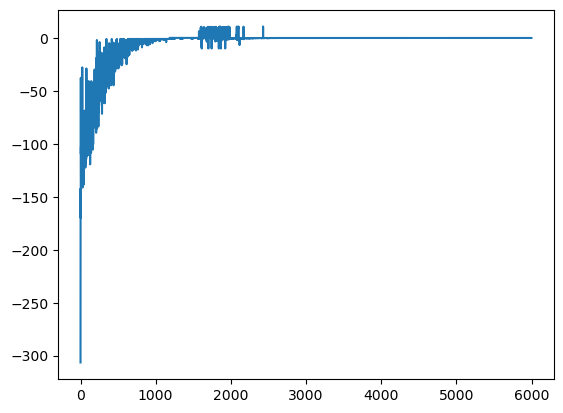

In [86]:
q_learning.plot_rewards()

Starting state is '20'


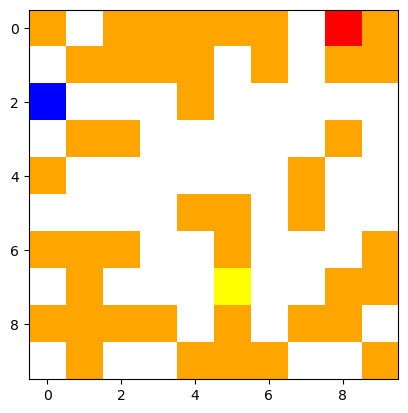

[-0.06461143 -0.06461143 -1.02989517 -0.05472582]
3
-0.005


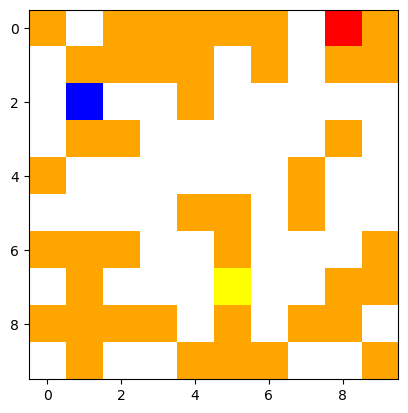

[-1.0249251 -1.0249251 -0.0596711 -0.0497756]
3
-0.005


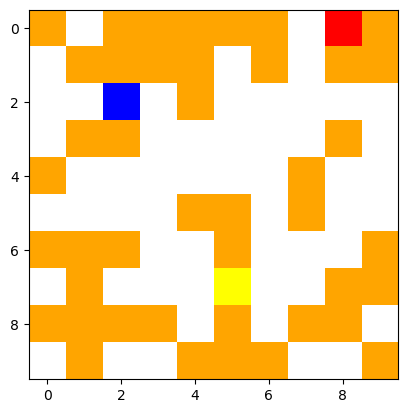

[-1.01995005 -1.01497002 -0.05472582 -0.04482042]
3
-0.005


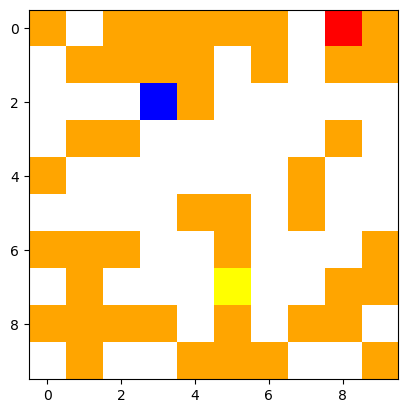

[-1.01497002 -0.03986028 -0.0497756  -1.01497002]
1
-0.005


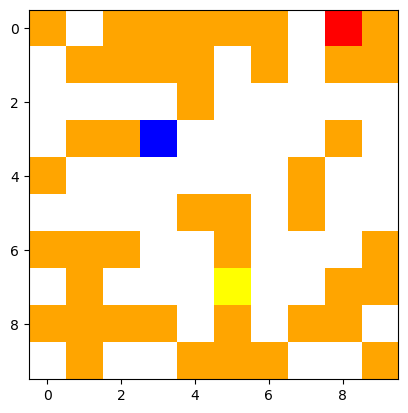

[-0.04482042 -0.04482042 -1.00998501 -0.03489517]
3
-0.005


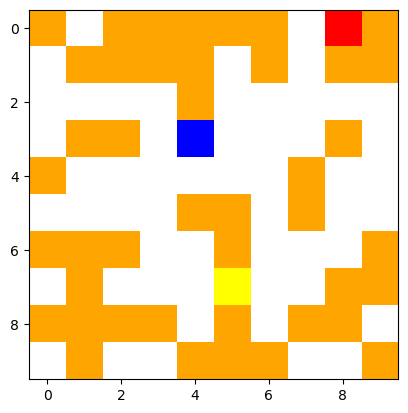

[-1.01497002 -0.03986028 -0.03986028 -0.0299251 ]
3
-0.005


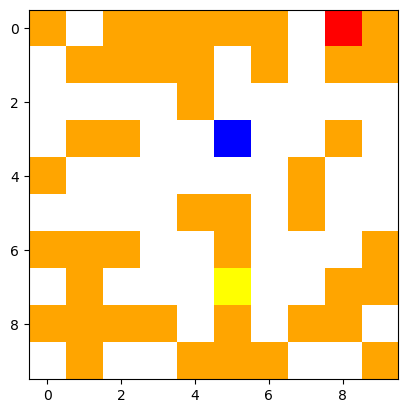

[-0.02495005 -0.03489517 -0.03489517 -0.02495005]
0
-0.005


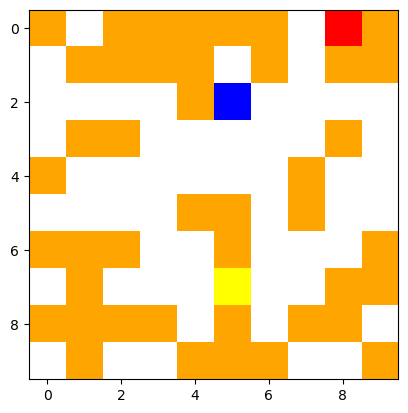

[-0.0299251  -0.0299251  -1.004995   -0.01997002]
3
-0.005


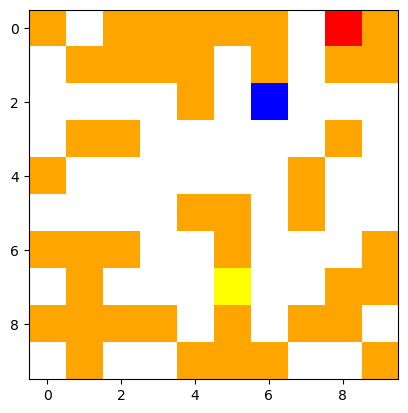

[-1.00998501 -0.02495005 -0.02495005 -0.014985  ]
3
-0.005


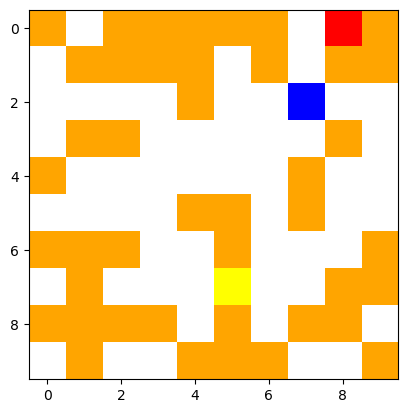

[-0.009995   -0.01997002 -0.01997002 -0.01997002]
0
-0.005


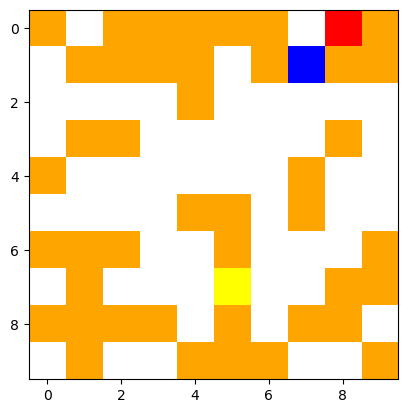

[-0.005    -0.014985 -1.004995 -1.004995]
0
-0.005


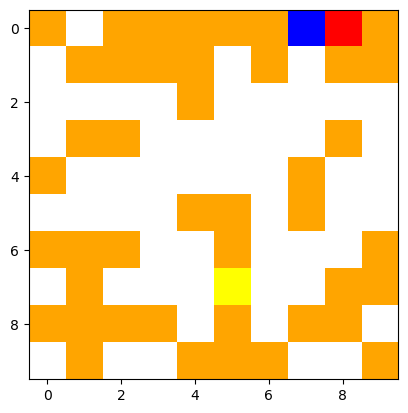

[-1.       -0.009995 -1.        0.      ]
3
Reached Target!
(0, 8)
0


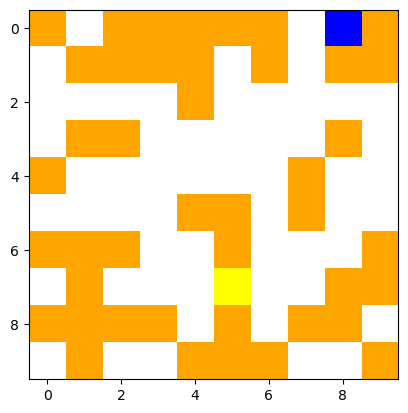

Episode Reward -0.05499999999999999.Q matrix values:
[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-1.  -0.  -1.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-1.  -0.1 -1.  -1. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-1.  -0.  -1.  -1. ]
 [ 0.   0.   0.   0. ]
 [-0.  -0.  -1.  -1. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.1 -0.1 -1.  -0.1]
 [-1.  -1.  -0.1 -0. ]
 [-1.  -1.  -0.1 -0. ]
 [-1.  -0.  -0.  -1. ]
 [ 0.   0.   0.   0. ]
 [-0.  -0.  -1.  -0. ]
 [-1.  -0.  -0.  -0. ]
 [-0.  -0.  -0.  -0. ]
 [-1.  -1.  -0.  -0. ]
 [-1.  -0.  -0.  -1. ]
 [-0.1 -1.  -1.  -1. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-0.  -0.  -1.  -0. ]
 [-1.  -0.  -0.  -0. ]
 [-0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.  -0. ]
 [-0.  -1.  -0.  -1. ]
 [ 0.   0.   0.   0. ]
 [-0.  -0.  -1.  -1. ]
 [ 0.   0.   0.   0. ]
 [-1

In [87]:
q_learning.test(50)

In [88]:
q_learning.show_Q_spec((5,6))
q_learning.show_Q_spec((3,5))
q_learning.show_Q_spec((4,5))

[-0.0299251  -0.03986028 -1.         -1.        ]
[-0.02495005 -0.03489517 -0.03489517 -0.02495005]
[-0.0299251  -1.01497002 -0.03986028 -0.0299251 ]


In [ ]:
7
